In [1]:
import os
import glob
from pyspark.sql import SparkSession

# Caminho da pasta de saída
output_folder = "../Scripts/output"

# Obter lista de arquivos CSV de blocos
block_files = glob.glob(os.path.join(output_folder, "block", "*.csv"))

# Obter lista de arquivos CSV de swaps
swap_files = glob.glob(os.path.join(output_folder, "swap", "*.csv"))

# Obter lista de arquivos CSV de transações
transaction_files = glob.glob(os.path.join(output_folder, "transaction", "*.csv"))

In [2]:
# Criar sessão Spark

import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

spark = SparkSession.builder \
    .appName("Análise de Transações Ethereum") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

In [3]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_block_df = None

file_path = "../Scripts/output/block/block.csv"

# Ler o arquivo CSV
combined_block_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [4]:
combined_block_df = combined_block_df.drop("Gas_Limit")
combined_block_df = combined_block_df.drop("Gas_Used")
combined_block_df = combined_block_df.drop("Timestamp_Block")

In [5]:
# Criar um DataFrame vazio para armazenar os dados dos blocos
combined_swap_df = None

file_path = "../Scripts/output/swap/swap_transactions.csv"

# Ler o arquivo CSV
combined_swap_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [6]:
combined_swap_df = combined_swap_df.drop("Block_ID")

In [7]:
combined_transaction_df = None

file_path = "../Scripts/output/transaction/transactions.csv"

# Ler o arquivo CSV
combined_transaction_df = spark.read.csv(file_path, header=True, inferSchema=True)

In [8]:
combined_swap_df_cleaned = combined_swap_df.dropna(subset=['From_Token_Symbol', 'To_Token_Symbol', 'From_Token_Holders_Count', 'To_Token_Holders_Count', 'From_Token_Price', 'To_Token_Price'])

from pyspark.sql.functions import when, col

combined_swap_df_cleaned = combined_swap_df_cleaned.withColumn("From_Token_Price", when(col("From_Token_Price") == 0, float('nan')).otherwise(col("From_Token_Price")))
combined_swap_df_cleaned = combined_swap_df_cleaned.withColumn("To_Token_Price", when(col("To_Token_Price") == 0, float('nan')).otherwise(col("To_Token_Price")))

In [9]:
df_combined = combined_block_df.join(combined_transaction_df, "Block_ID").join(combined_swap_df_cleaned, "Hash_Transaction")

In [10]:
df_combined_pandas = df_combined.toPandas()
df_combined_pandas.to_csv('combined_df.csv', index=False)

In [11]:
from pyspark.sql import functions as F

# Filtrar as transações de compra
compras_df = df_combined.filter(df_combined.To_Token_Symbol.isNotNull()) \
               .groupBy("To_Token_Symbol") \
               .agg(F.count("*").alias("Num_Compras")) \
               .orderBy(F.desc("Num_Compras")) \
               .limit(10)

# Filtrar as transações de venda
vendas_df = df_combined.filter(df_combined.From_Token_Symbol.isNotNull()) \
              .groupBy("From_Token_Symbol") \
              .agg(F.count("*").alias("Num_Vendas")) \
              .orderBy(F.desc("Num_Vendas")) \
              .limit(10)

# Exibir as 10 moedas mais compradas
print("As 10 moedas mais compradas:")
compras_df.show()

# Exibir as 10 moedas mais vendidas
print("As 10 moedas mais vendidas:")
vendas_df.show()

As 10 moedas mais compradas:
+---------------+-----------+
|To_Token_Symbol|Num_Compras|
+---------------+-----------+
|           WETH|        327|
|         BOBINU|         68|
|         PEPINU|         32|
|          pɛpeɪ|         24|
|         WOJINU|         22|
|       FLOKIINU|         18|
|          Shinu|         14|
|          PEPIG|         14|
|        INUPEPE|         14|
|        DogeInu|         14|
+---------------+-----------+

As 10 moedas mais vendidas:
+-----------------+----------+
|From_Token_Symbol|Num_Vendas|
+-----------------+----------+
|             WETH|       327|
|         FLOKIINU|        37|
|           BOBINU|        28|
|          PEPECAT|        25|
|           WOJINU|        21|
|             PINU|        20|
|           PEPINU|        18|
|          PEWOJAK|        16|
|          DogeInu|        14|
|            Shinu|        14|
+-----------------+----------+



In [12]:
from pyspark.sql import functions as F

# Filtrar as transações de compra
compras_df = df_combined.filter(df_combined.To_Token_Symbol.isNotNull()) \
                       .groupBy("Timestamp_Transaction", "To_Token_Symbol") \
                       .agg(F.sum("To_Token_Holders_Count").alias("Total_Holders")) \
                       .withColumnRenamed("To_Token_Symbol", "Token_Symbol")

# Filtrar as transações de venda
vendas_df = df_combined.filter(df_combined.From_Token_Symbol.isNotNull()) \
                      .groupBy("Timestamp_Transaction", "From_Token_Symbol") \
                      .agg(F.sum("From_Token_Holders_Count").alias("Total_Holders")) \
                      .withColumnRenamed("From_Token_Symbol", "Token_Symbol")

# Unir os resultados das transações de compra e venda
result_df = compras_df.unionAll(vendas_df)

# Calcular a média de holders por Token_Symbol
media_df = result_df.groupBy("Token_Symbol") \
                    .agg(F.mean("Total_Holders").alias("Media_Holders")) \
                    .orderBy(F.desc("Media_Holders")) \
                    .limit(10)

# Exibir o resultado
media_df.show()

+------------+------------------+
|Token_Symbol|     Media_Holders|
+------------+------------------+
|        USDT|         4410427.0|
|        WETH|4110512.7829457363|
|         NaN| 271132.3333333333|
|     PEPE2.0|           13794.0|
|         VOW|           12857.5|
|    SQUID2.0|            3568.0|
|       LAMBO|            3472.0|
|      UNI-V2|            3455.0|
|     DOGE2.0|            2814.0|
| vitalik.eth|            2730.0|
+------------+------------------+



In [13]:
import matplotlib.pyplot as plt

# Obtenha as 10 moedas mais compradas
top_10_compradas = df_combined.filter(df_combined.To_Token_Symbol.isNotNull()) \
                             .groupBy("To_Token_Symbol") \
                             .count() \
                             .orderBy(F.desc("count")) \
                             .limit(10) \
                             .select("To_Token_Symbol")

# Obtenha as transações de compra de determinada moeda e o número de holders
compras_df = df_combined.alias("compras") \
                       .join(top_10_compradas, top_10_compradas.To_Token_Symbol == df_combined.To_Token_Symbol, "inner") \
                       .select("compras.Timestamp_Transaction", "compras.To_Token_Symbol", "compras.To_Token_Holders_Count") \
                       .withColumnRenamed("To_Token_Symbol", "Token_Symbol") \
                       .withColumnRenamed("To_Token_Holders_Count", "Token_Holders_Count")

# Obtenha as transações de venda de determinada moeda e o número de holders
vendas_df = df_combined.alias("vendas") \
                      .join(top_10_compradas, top_10_compradas.To_Token_Symbol == df_combined.From_Token_Symbol, "inner") \
                      .select("vendas.Timestamp_Transaction", "vendas.From_Token_Symbol", "vendas.From_Token_Holders_Count") \
                      .withColumnRenamed("From_Token_Symbol", "Token_Symbol") \
                      .withColumnRenamed("From_Token_Holders_Count", "Token_Holders_Count")

result_df = compras_df.unionAll(vendas_df)

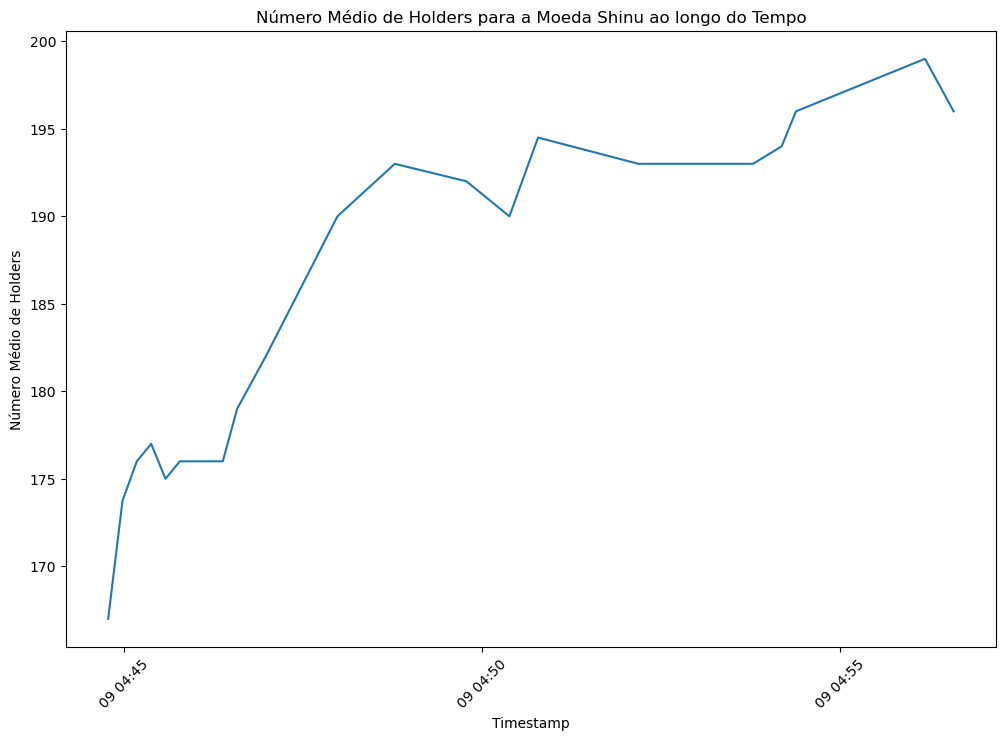

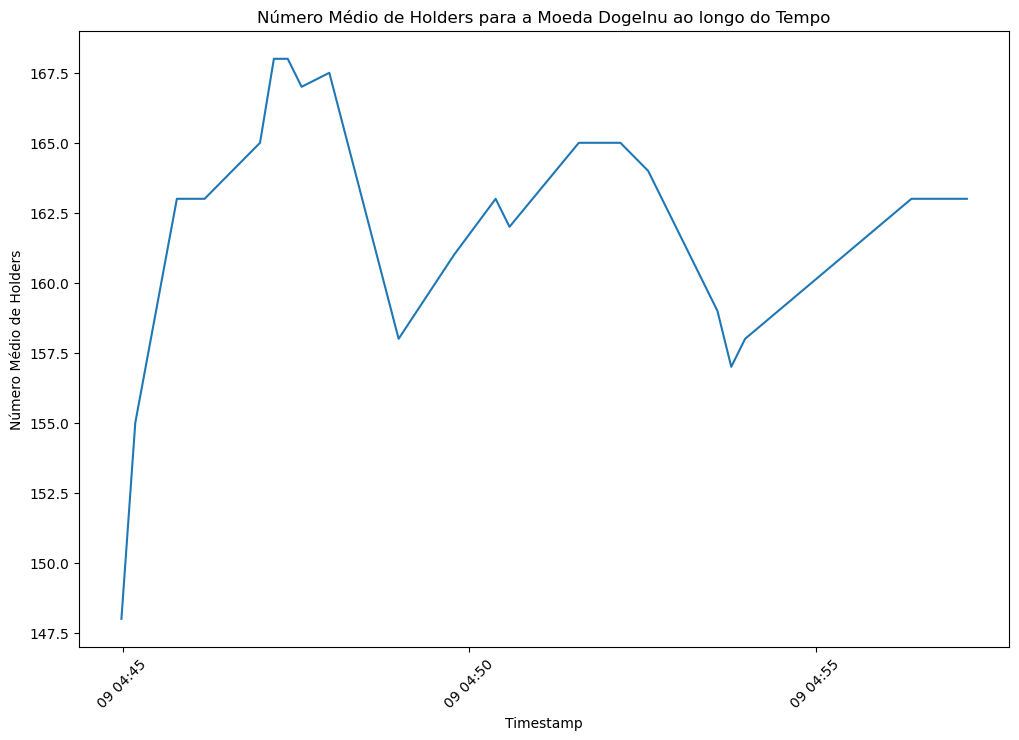

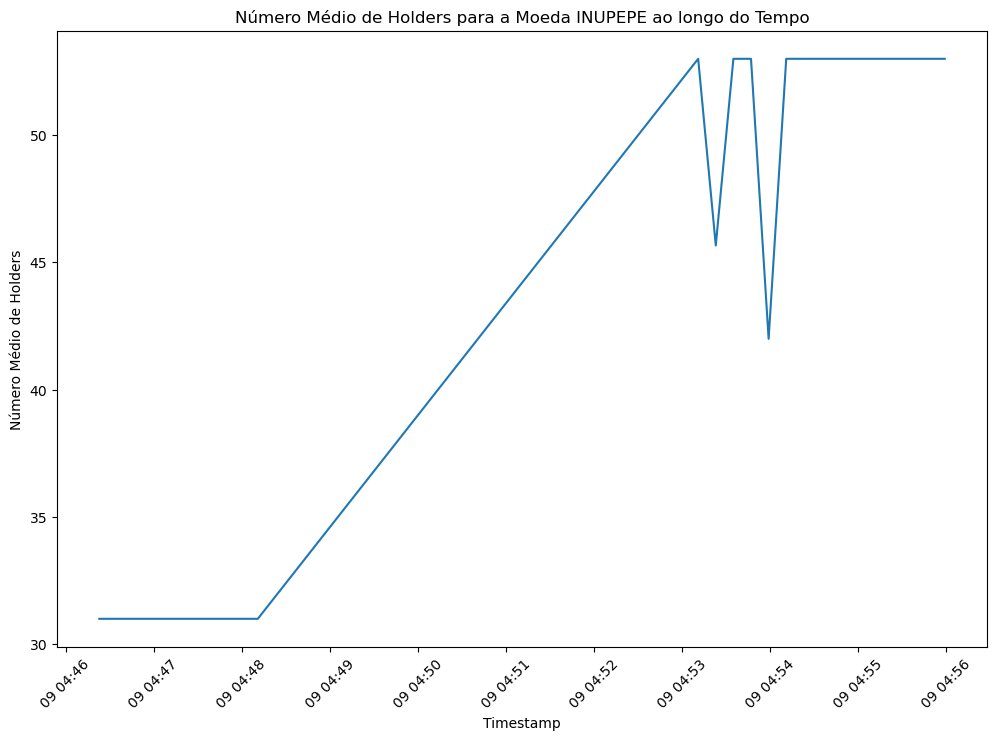

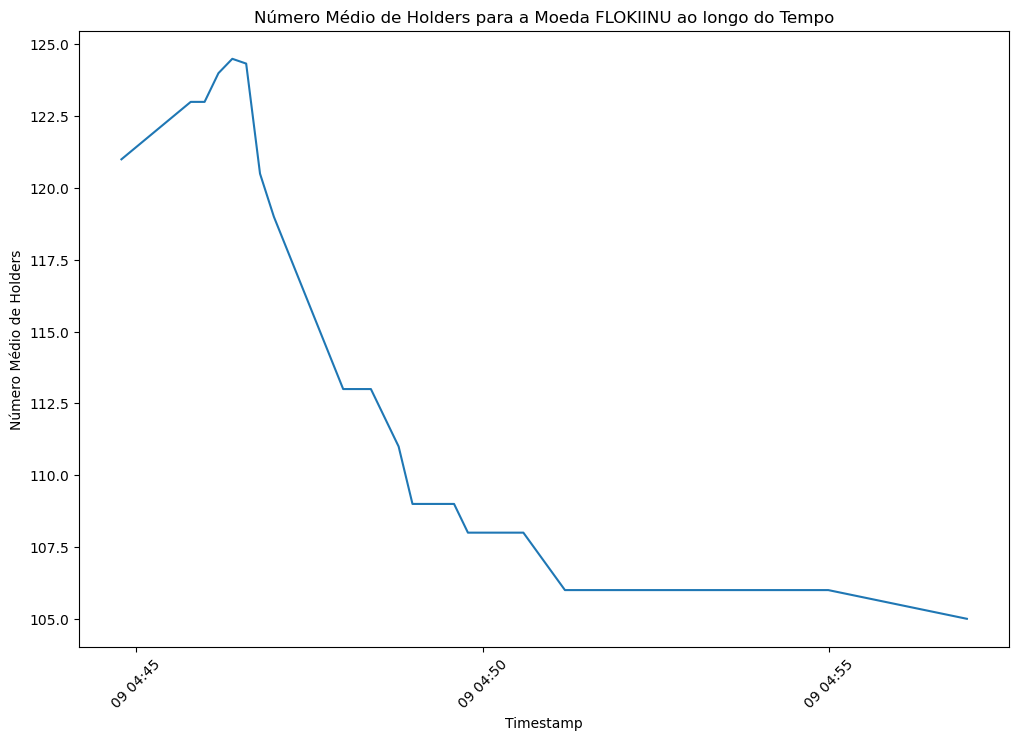

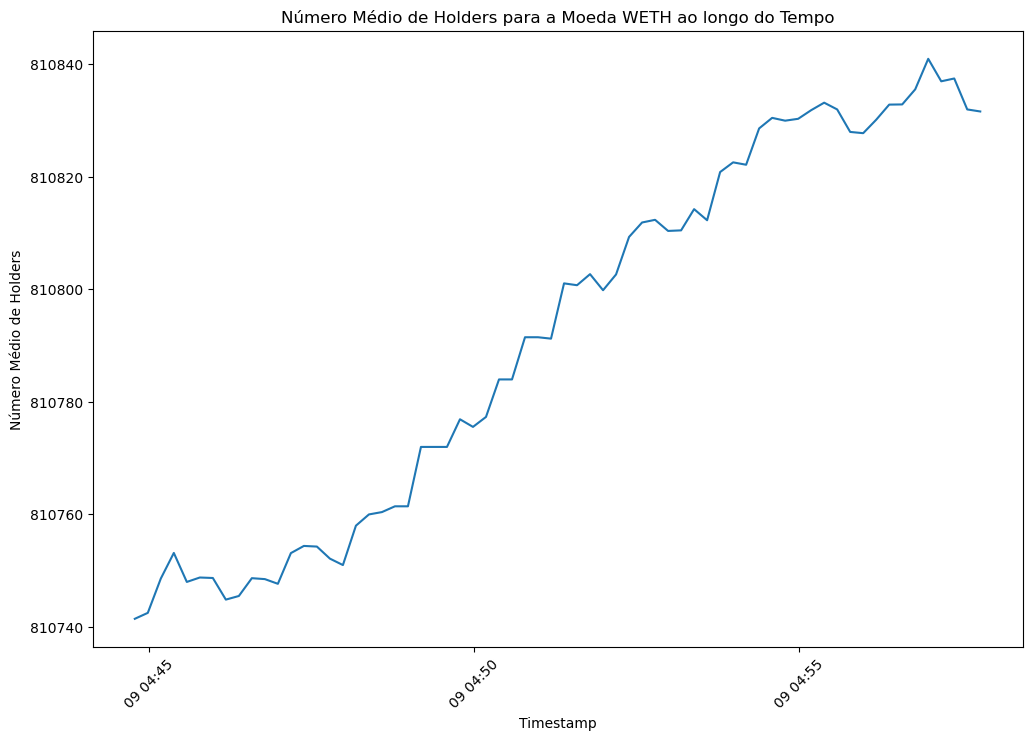

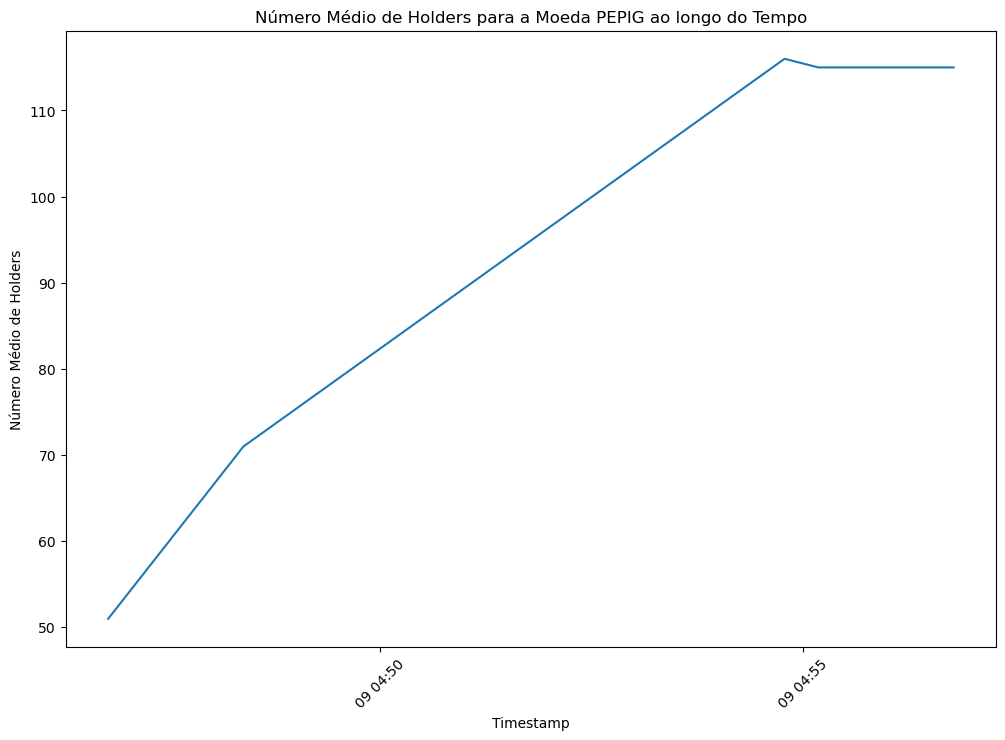

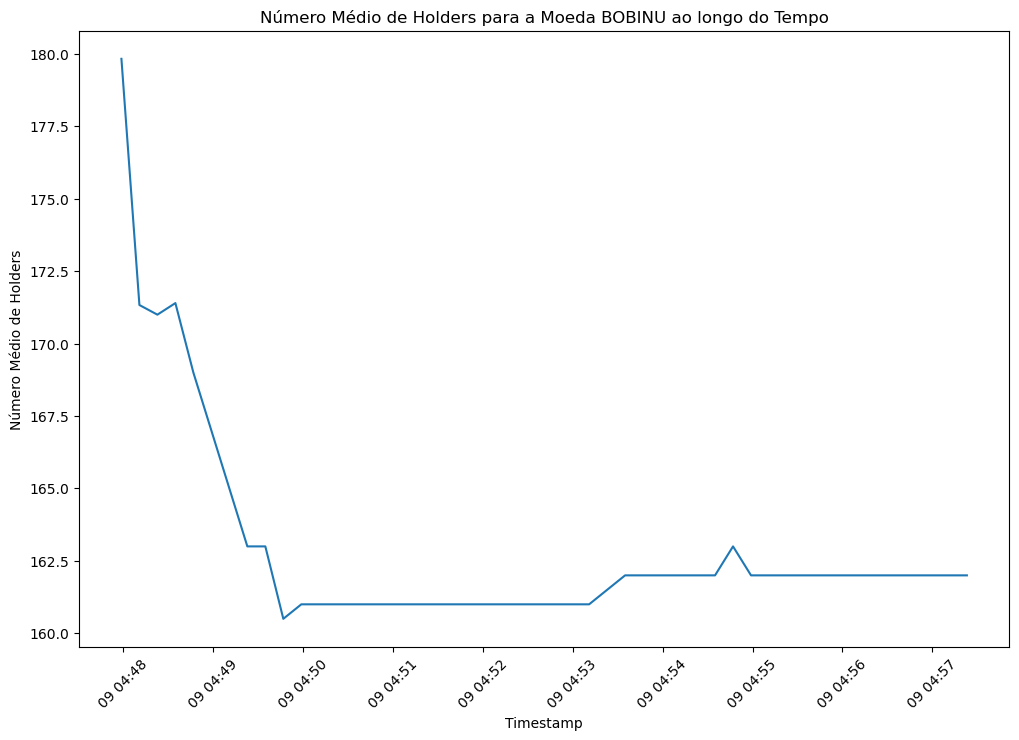

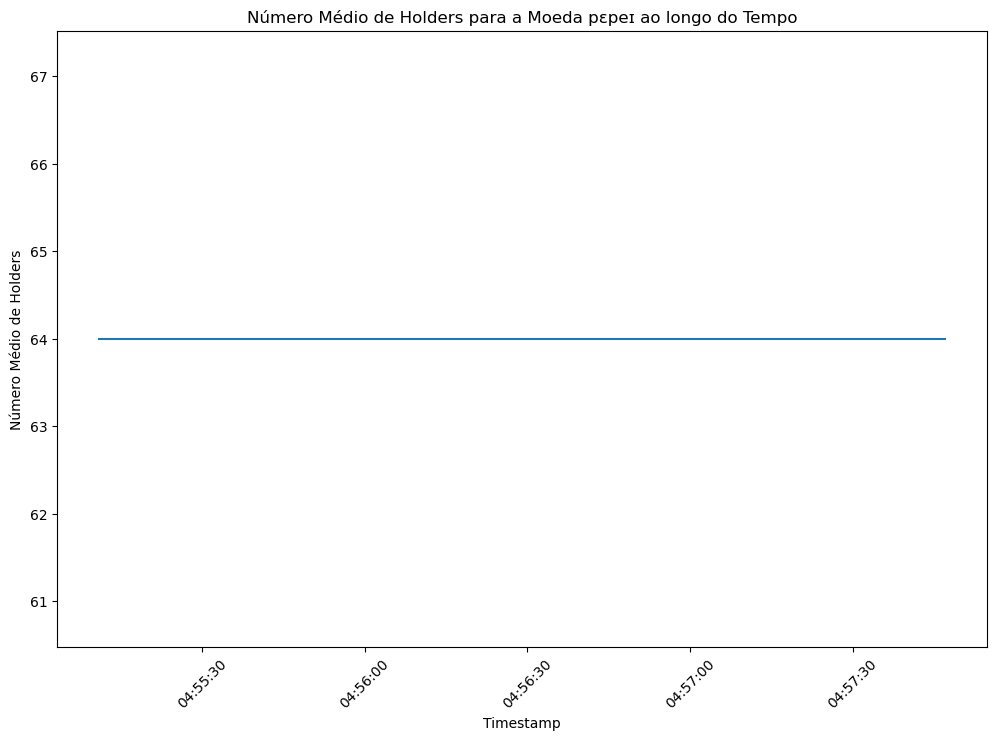

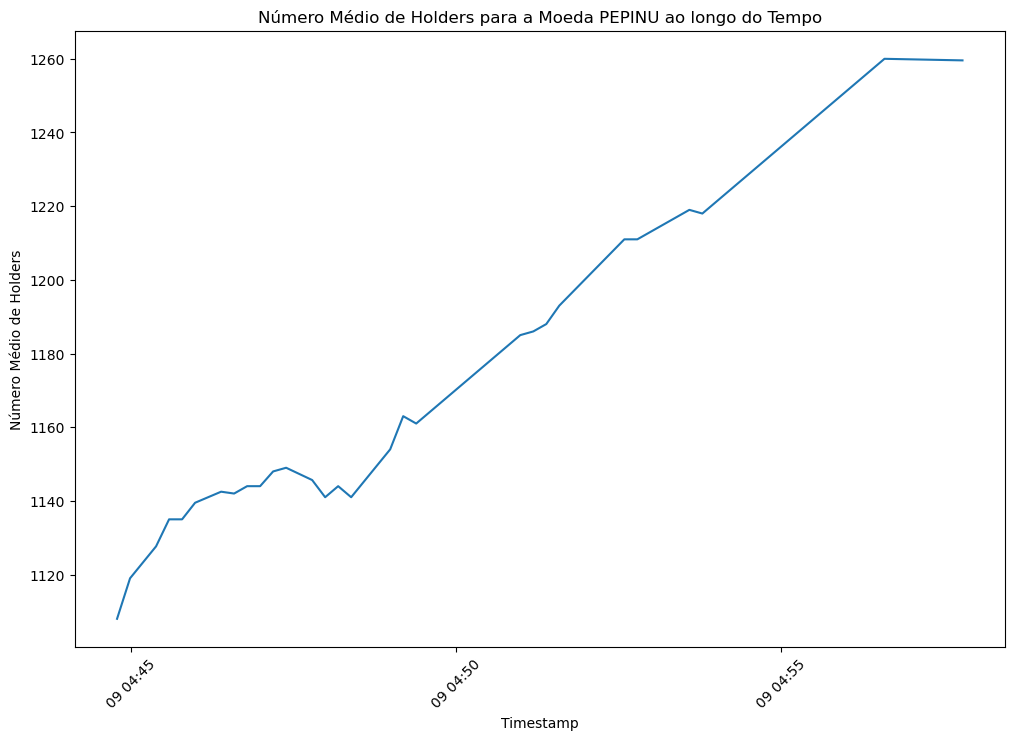

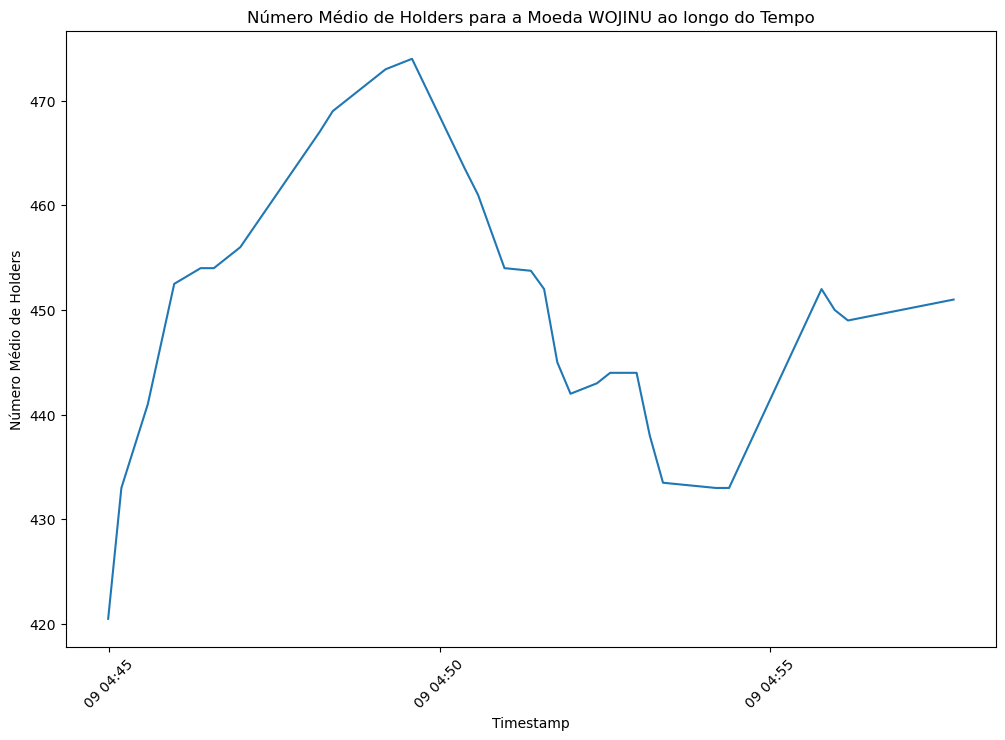

In [14]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg
from pyspark.sql.functions import collect_list, struct
import datetime

# Agrupe o dataframe e calcule a média do número de holders para cada moeda em cada timestamp
grouped_df = result_df.groupBy("Timestamp_Transaction", "Token_Symbol").avg("Token_Holders_Count")

# Ordene o dataframe pelo campo "Timestamp_Transaction"
sorted_df = grouped_df.orderBy("Timestamp_Transaction")

# Coleta os dados do dataframe para uso no matplotlib
data_dict = {}

# Agrupe o dataframe e calcule a média do número de holders para cada moeda em cada timestamp
grouped_df = sorted_df.groupBy("Token_Symbol").agg(collect_list(struct("Timestamp_Transaction", "avg(Token_Holders_Count)")).alias("data_list"))

# Converta o resultado em um dicionário
data_dict = {row["Token_Symbol"]: {"timestamps": [r["Timestamp_Transaction"] for r in row["data_list"]],
                                    "holders_counts": [r["avg(Token_Holders_Count)"] for r in row["data_list"]]}
             for row in grouped_df.collect()}

# Itera sobre os dados do dicionário
for symbol, data in data_dict.items():
    timestamps = data["timestamps"]
    holders_counts = data["holders_counts"]

    # Converte os timestamps em formato Unix para formato de data e hora
    dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

    # Plota o gráfico
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(dates, holders_counts, label=symbol)
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Número Médio de Holders")
    ax.set_title(f"Número Médio de Holders para a Moeda {symbol} ao longo do Tempo")

    # Rotaciona os rótulos do eixo x
    plt.xticks(rotation=45)

    plt.show()

In [21]:
import matplotlib.pyplot as plt

# Obtenha as 10 moedas mais vendidas
top_10_vendidas = df_combined.filter(df_combined.From_Token_Symbol.isNotNull()) \
                             .groupBy("From_Token_Symbol") \
                             .count() \
                             .orderBy(F.desc("count")) \
                             .limit(10) \
                             .select("From_Token_Symbol")

# Obtenha as transações de compra de determinada moeda e o número de holders
compras_df = df_combined.alias("compras") \
                       .join(top_10_vendidas, top_10_vendidas.From_Token_Symbol == df_combined.To_Token_Symbol, "inner") \
                       .select("compras.Timestamp_Transaction", "compras.To_Token_Symbol", "compras.To_Token_Holders_Count") \
                       .withColumnRenamed("To_Token_Symbol", "Token_Symbol") \
                       .withColumnRenamed("To_Token_Holders_Count", "Token_Holders_Count")

# Obtenha as transações de venda de determinada moeda e o número de holders
vendas_df = df_combined.alias("vendas") \
                      .join(top_10_vendidas, top_10_vendidas.From_Token_Symbol == df_combined.From_Token_Symbol, "inner") \
                      .select("vendas.Timestamp_Transaction", "vendas.From_Token_Symbol", "vendas.From_Token_Holders_Count") \
                      .withColumnRenamed("From_Token_Symbol", "Token_Symbol") \
                      .withColumnRenamed("From_Token_Holders_Count", "Token_Holders_Count")

result_df = compras_df.unionAll(vendas_df)

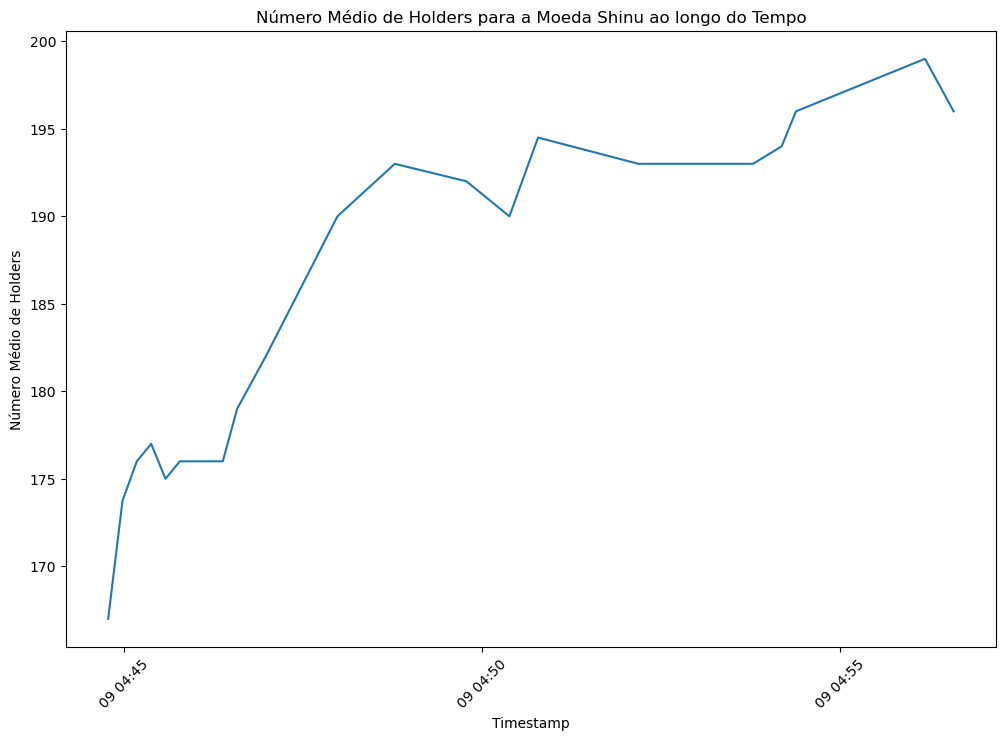

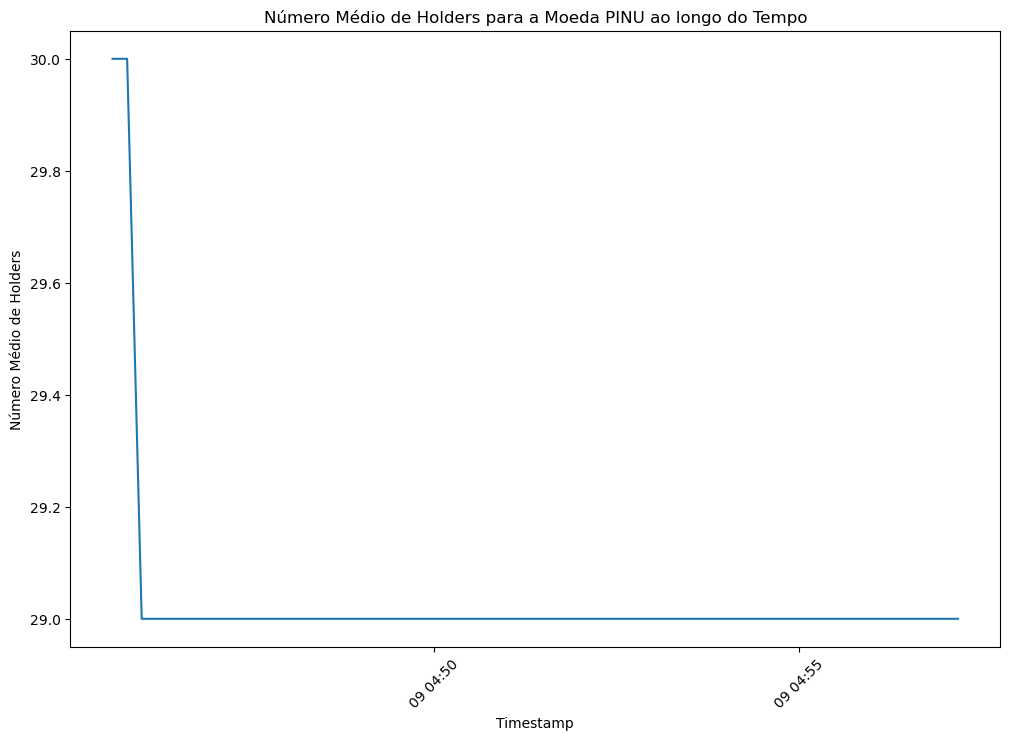

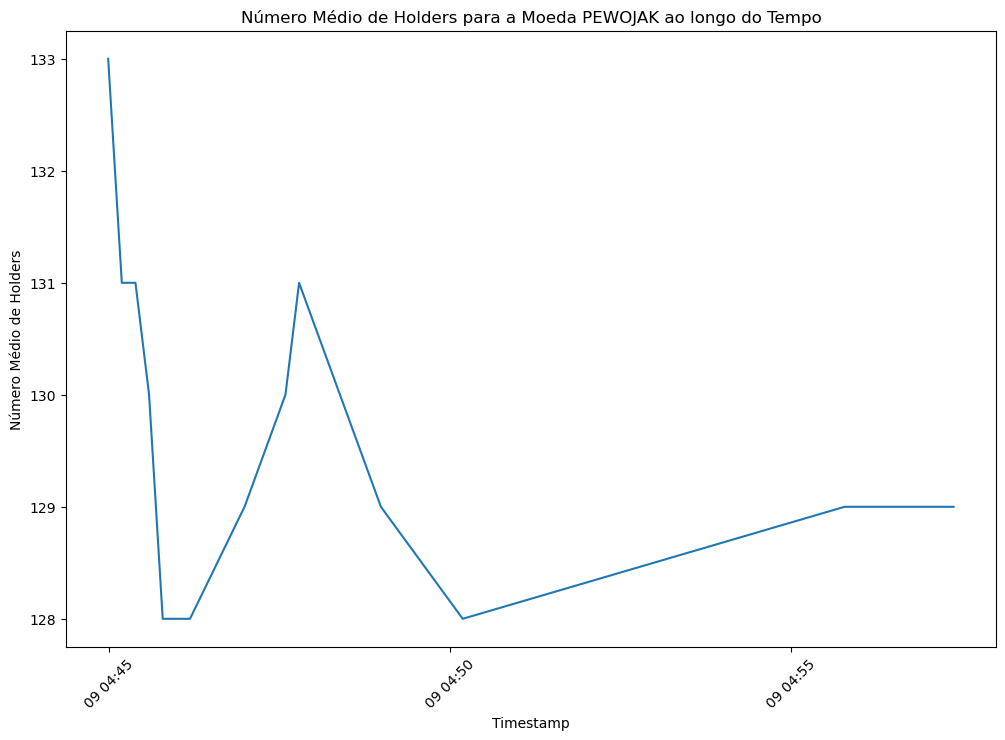

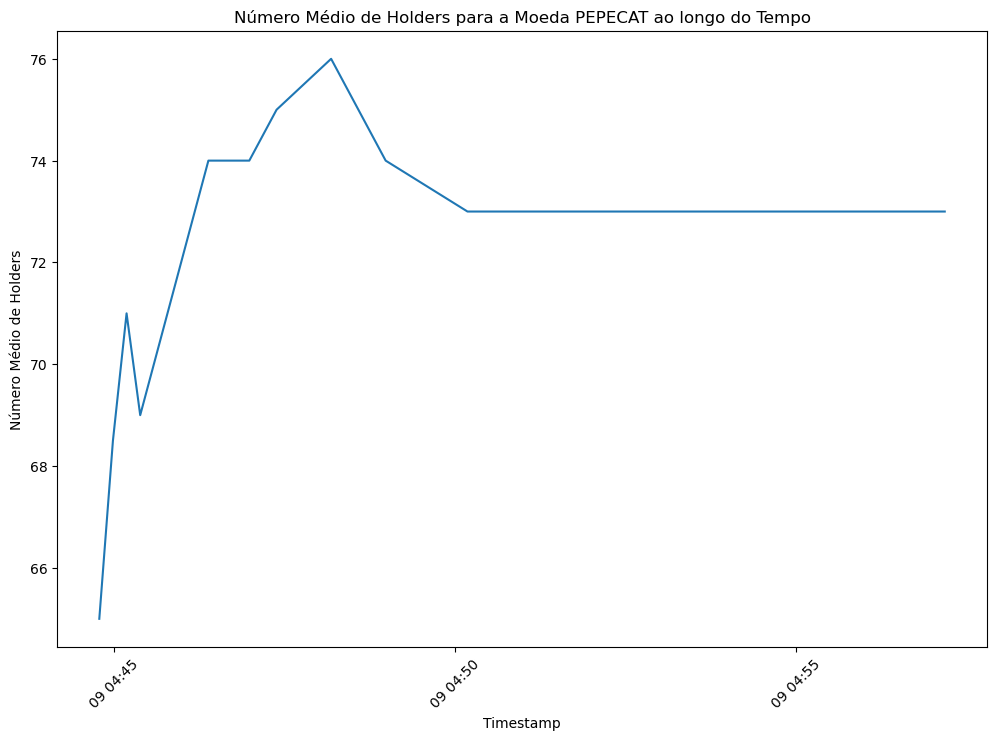

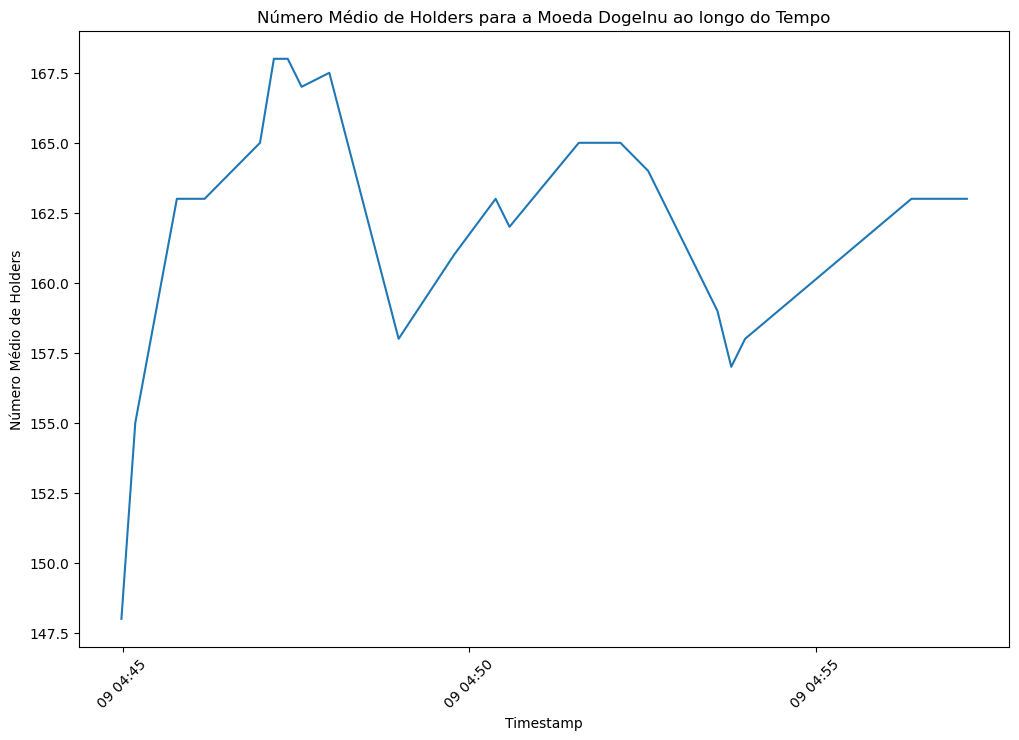

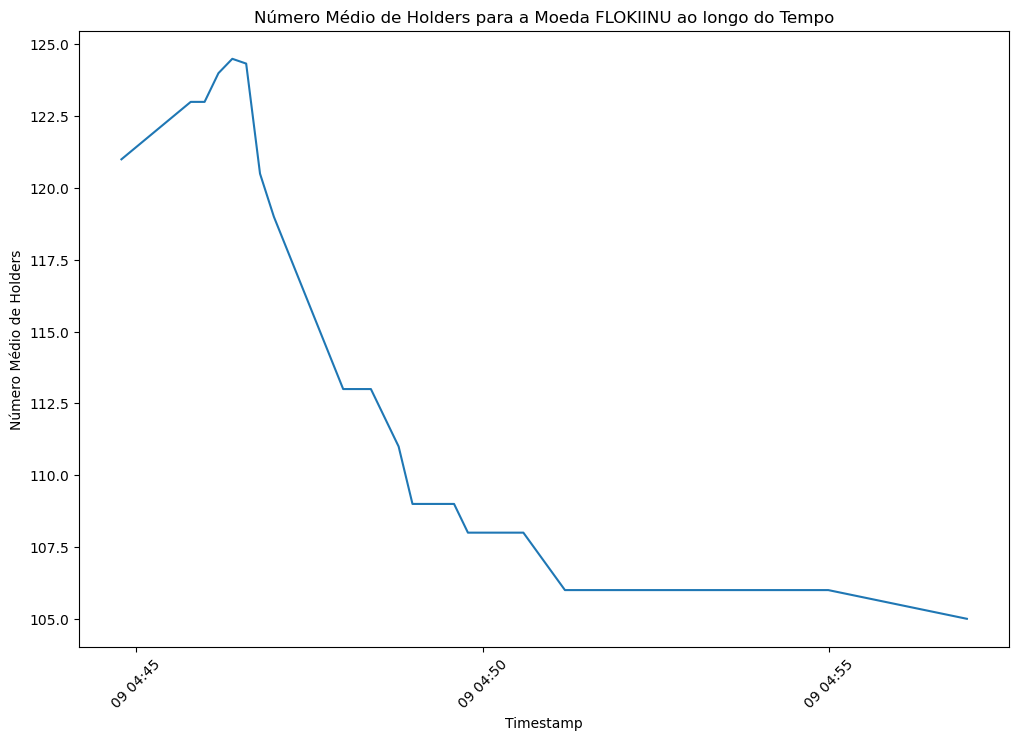

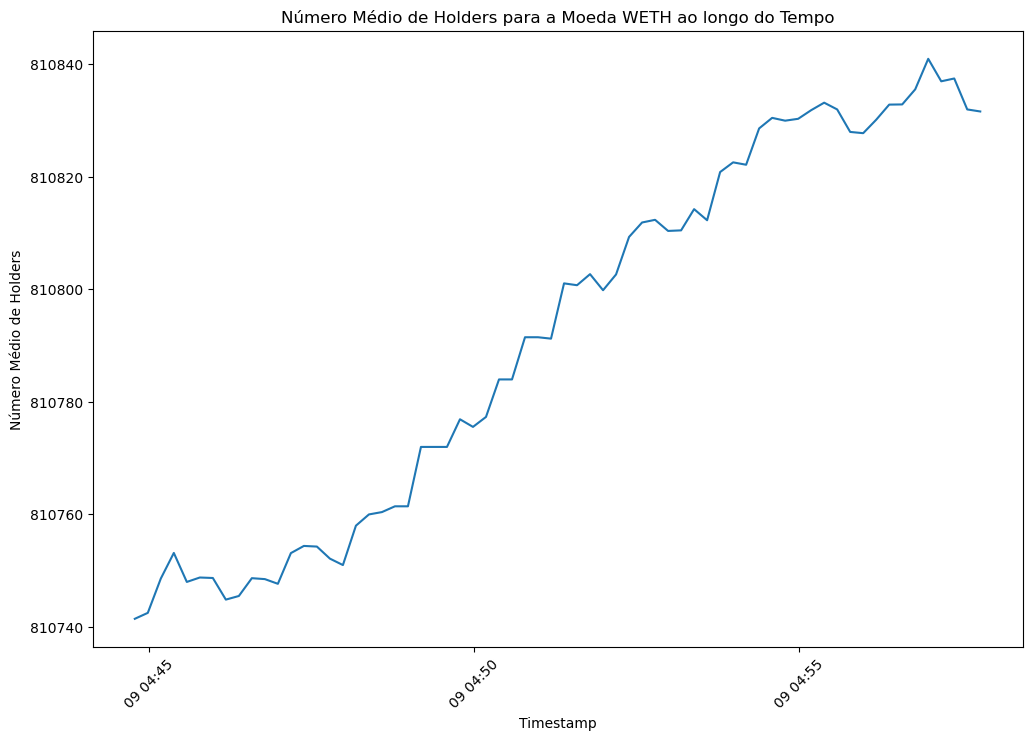

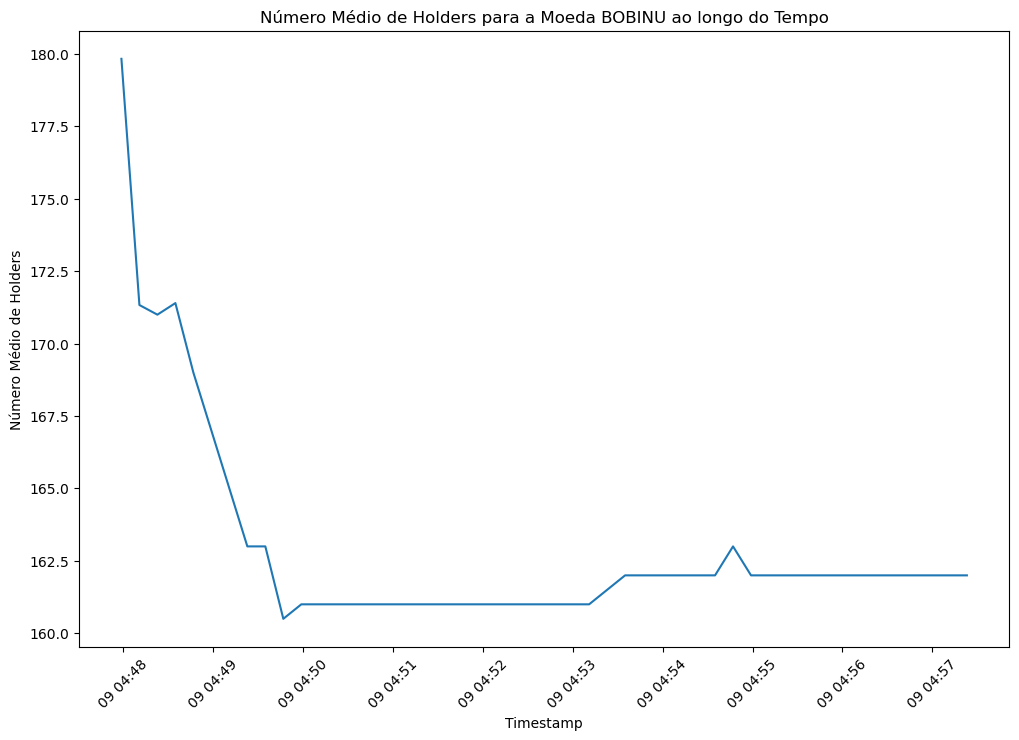

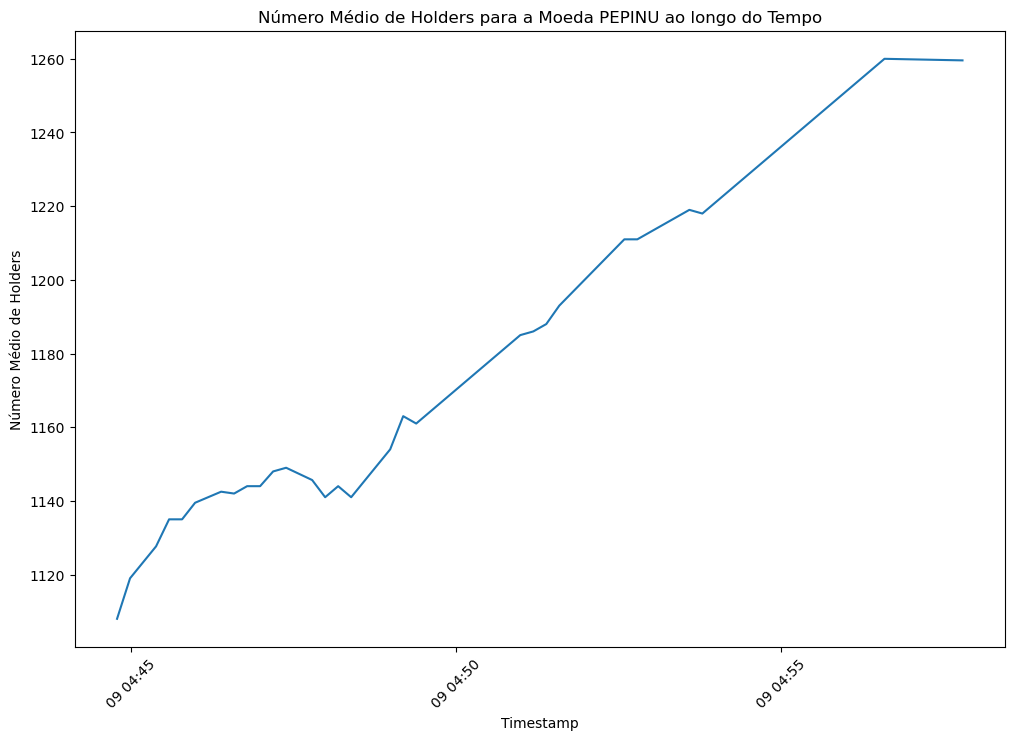

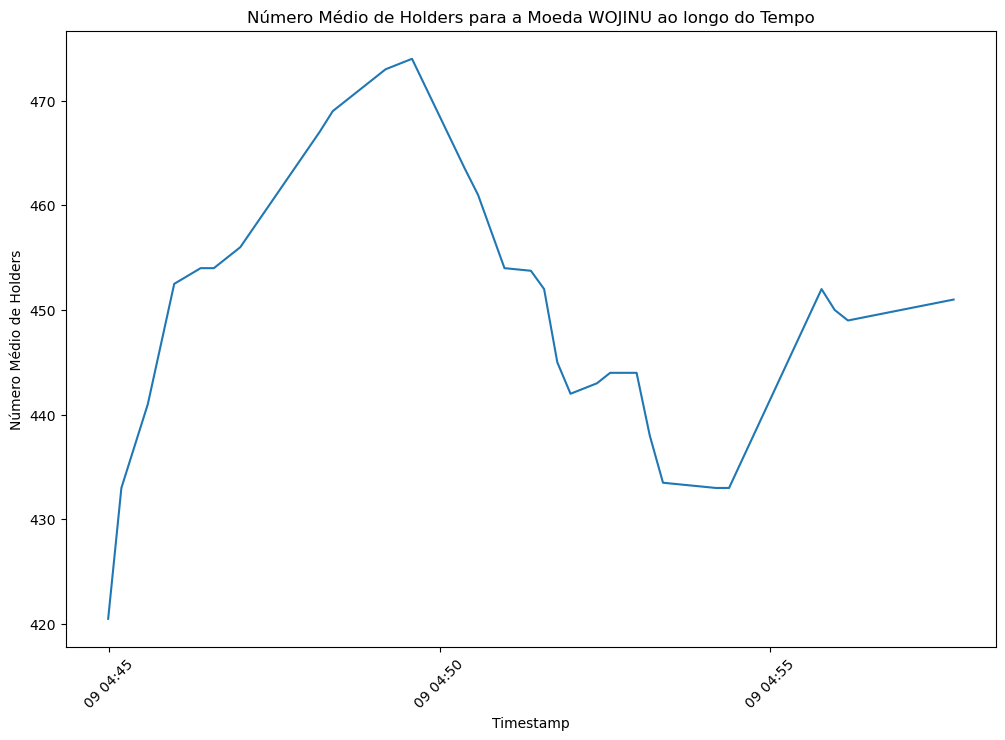

In [22]:
import matplotlib.pyplot as plt
from pyspark.sql.functions import avg
from pyspark.sql.functions import collect_list, struct
import datetime

# Agrupe o dataframe e calcule a média do número de holders para cada moeda em cada timestamp
grouped_df = result_df.groupBy("Timestamp_Transaction", "Token_Symbol").avg("Token_Holders_Count")

# Ordene o dataframe pelo campo "Timestamp_Transaction"
sorted_df = grouped_df.orderBy("Timestamp_Transaction")

# Coleta os dados do dataframe para uso no matplotlib
data_dict = {}

# Agrupe o dataframe e calcule a média do número de holders para cada moeda em cada timestamp
grouped_df = sorted_df.groupBy("Token_Symbol").agg(collect_list(struct("Timestamp_Transaction", "avg(Token_Holders_Count)")).alias("data_list"))

# Converta o resultado em um dicionário
data_dict = {row["Token_Symbol"]: {"timestamps": [r["Timestamp_Transaction"] for r in row["data_list"]],
                                    "holders_counts": [r["avg(Token_Holders_Count)"] for r in row["data_list"]]}
             for row in grouped_df.collect()}

# Itera sobre os dados do dicionário
for symbol, data in data_dict.items():
    timestamps = data["timestamps"]
    holders_counts = data["holders_counts"]

    # Converte os timestamps em formato Unix para formato de data e hora
    dates = [datetime.datetime.fromtimestamp(ts) for ts in timestamps]

    # Plota o gráfico
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(dates, holders_counts, label=symbol)
    ax.set_xlabel("Timestamp")
    ax.set_ylabel("Número Médio de Holders")
    ax.set_title(f"Número Médio de Holders para a Moeda {symbol} ao longo do Tempo")

    # Rotaciona os rótulos do eixo x
    plt.xticks(rotation=45)

    plt.show()